In [3]:
import os
os.chdir('/home/jennifer.badolato/watttime-python-client-aer-algo/')

import numpy as np
import pandas as pd
import datetime
import random
import pytz
from datetime import datetime, timedelta
import random
from watttime import WattTimeMyAccess, WattTimeHistorical, WattTimeForecast, WattTimeMaps
import os
import optimizer.dataset as od
from evaluation.config import MOER_REGION_LIST
import evaluation.eval_framework as evu
import optimizer.s3 as s3u

import seaborn as sns
import matplotlib.pyplot as plt

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

In [21]:
#import importlib
#importlib.reload(evu)

<module 'evaluation.eval_framework' from '/home/jennifer.badolato/watttime-python-client-aer-algo/evaluation/eval_framework.py'>

In [19]:
start = "2024-02-01 00:00Z"
end = "2024-02-15 00:00Z"

distinct_date_list = [
    pd.Timestamp(date).replace(tzinfo=pytz.UTC)
    for date in pd.date_range(start, end, freq="d", tz=pytz.UTC).values
]

In [22]:
dfs = evu.execute_synth_data_process(distinct_date_list, number_of_users=1000)

100%|██████████| 1000/1000 [00:10<00:00, 91.18it/s]


In [24]:
s3 = s3u.s3_utils()
key = '20240701_1k_synth_users.csv'
s3.store_csvdataframe(dataframe=dfs, file=key)

Successful S3 put_object response. Status - 200


## Distributions

In [25]:
dfs.uncharged.value_counts()

uncharged
False    12451
True      2549
Name: count, dtype: int64

Text(0.5, 1.0, 'length_plugged_in')

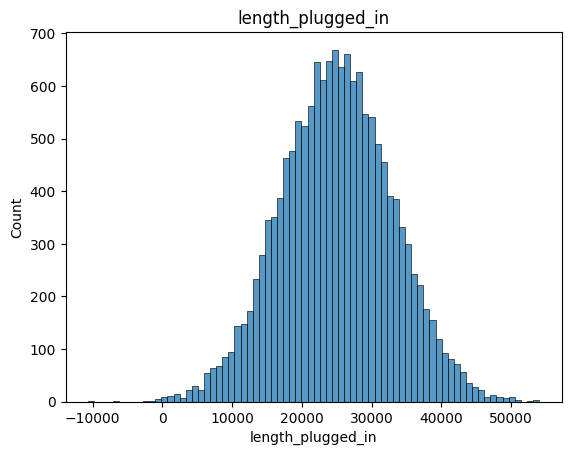

In [6]:
sns.histplot(dfs["length_plugged_in"]).set_title("length_plugged_in")

Text(0.5, 1.0, 'total_seconds_to_95')

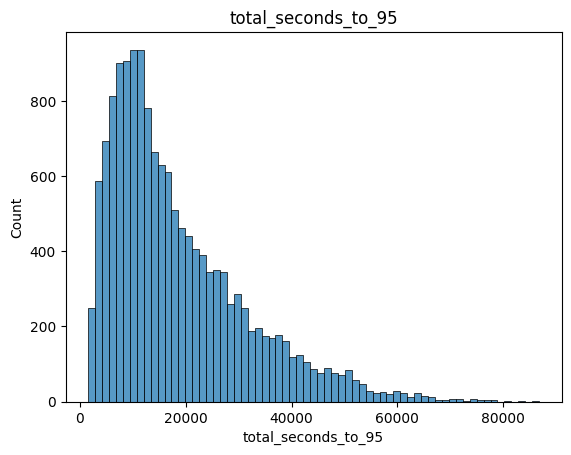

In [7]:
sns.histplot(dfs["total_seconds_to_95"]).set_title("total_seconds_to_95")

Text(0.5, 1.0, 'final_perc_charged')

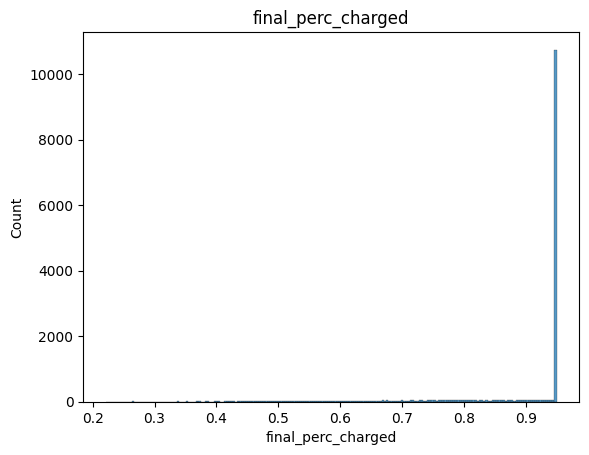

In [8]:
sns.histplot(dfs["final_perc_charged"]).set_title("final_perc_charged")

Text(0.5, 1.0, 'total_capacity')

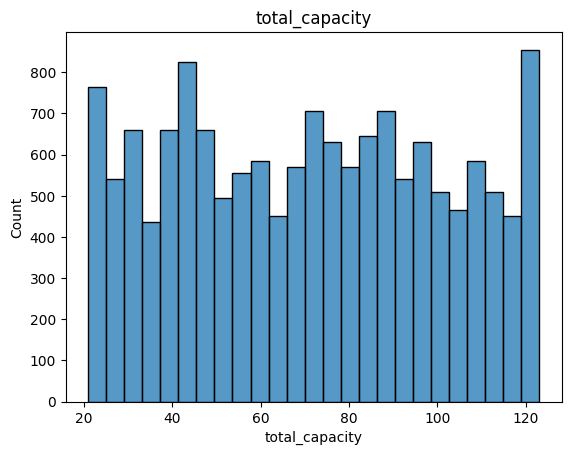

In [9]:
sns.histplot(dfs["total_capacity"]).set_title("total_capacity")

Text(0.5, 1.0, 'charged_kWh_actual')

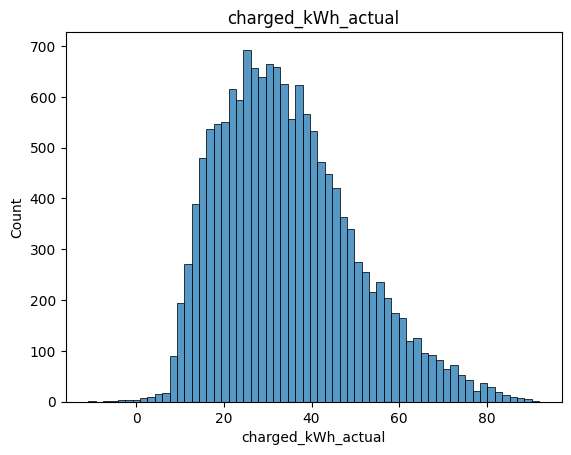

In [23]:
sns.histplot(dfs["charged_kWh_actual"]).set_title("charged_kWh_actual")

Text(0.5, 1.0, 'power_output_rate')

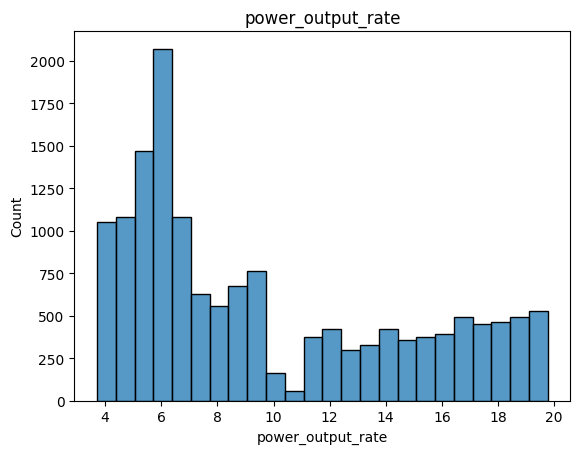

In [12]:
sns.histplot(dfs["power_output_rate"]).set_title("power_output_rate")

- TODO: plug + unplug needs to be specified in a local time + converted to UTC

# Calculate MOERs with no optimization

In [2]:
import os
os.chdir("/home/jennifer.badolato/watttime-python-client-aer-algo")

In [4]:
region = "PJM_NJ"
username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

actual_data = WattTimeHistorical(username, password)

In [5]:
s3 = s3u.s3_utils()
key = '20240701_1k_synth_users.csv'
generated_data = s3.load_csvdataframe(file=key)

In [6]:
def intervalize_power_rate(kW_value: float, convert_to_MW = True):
    five_min_rate = kW_value / 12
    if convert_to_MW:
        five_min_rate = five_min_rate / 1000
    else:
        five_min_rate
    return five_min_rate

def sum_moer_actuals(moer_data, MWh_fraction,plug_in_time, number_conseq_intervals):
    index_lower_limit = moer_data[moer_data.point_time > plug_in_time].index[0]
    index_upper_limit = index_lower_limit + int(number_conseq_intervals)
    return sum(
        moer_data[index_lower_limit: index_upper_limit]["value"] * MWh_fraction
        )

In [7]:
moer_actuals = actual_data.get_historical_pandas(
    start=generated_data.plug_in_time.min(),
    end=generated_data.unplug_time.max(),
    region=region
)

In [8]:
generated_data["MWh_fraction"] = generated_data["power_output_rate"].apply(intervalize_power_rate)
generated_data["number_intervals_drawing_power"] = generated_data.charged_kWh_actual / generated_data.power_output_rate * 60 / 5

In [9]:
generated_data["moer_actuals"] = generated_data.apply(
    lambda x: sum_moer_actuals(
        moer_actuals,
        x.MWh_fraction,
        x.plug_in_time,
        x.number_intervals_drawing_power
        ), axis=1
        )

Text(0.5, 1.0, 'MOER Actuals in lbs of CO2')

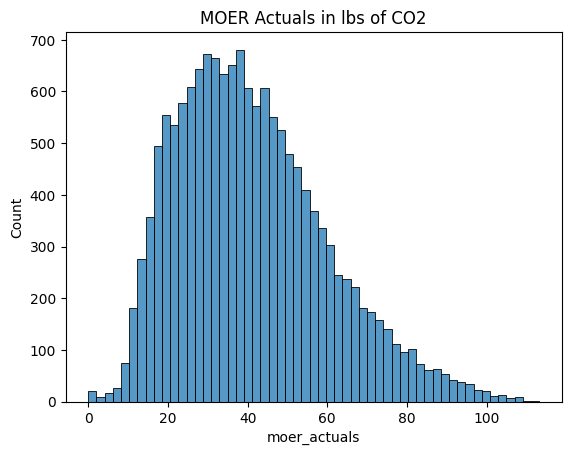

In [10]:
sns.histplot(generated_data["moer_actuals"]).set_title("MOER Actuals in lbs of CO2")